In [37]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo import samples, utils, metadata
from tqdm.notebook import trange, tqdm
import xarray as xr

In [2]:
# Wind Setup 
ref_height = 100      # power law reference height 
shear_exponent = 0.2  # power law shear exponent
wind_speed = 10       # wind speed at referenc height

# Base setup of LOS direction
# dis = 1000        # meters
angular_res = 1   # degrees
azimuth_mid = 0   # central azimuth angle

# Uncertainty terms
mu = 0 # we assume there is no bias
azim_std = 0.1 # degrees
elev_std = 0.1 # degrees
dis_std = 10   # meters
rad_std = 0.1  # m.s-1


# Setup loops
no_sim = 10000
diss = np.array([250, 500, 750, 1000, 2000, 3000, 4000, 5000])
corr_coefs = np.arange(0, 1 + 0.25, 0.25)
wind_dirs = np.arange(0, 360 + 5, 5)
sectors = np.arange(10, 90 + 5, 5)

# Setup results matrix
uncert = np.full((len(diss), len(corr_coefs), len(wind_dirs), len(sectors),2), np.nan)
for d, dis in enumerate(tqdm(diss, desc ="Distance loop")):
    for i,corr_coef in enumerate(tqdm(corr_coefs, desc ="Correletation loop", leave = False)):

        for j,wind_dir in enumerate(tqdm(wind_dirs, desc = "Wind direction loop", leave = False)):
            w = 0
            u = - wind_speed * np.sin(np.radians(wind_dir))
            v = - wind_speed * np.cos(np.radians(wind_dir))

            for k,sector in enumerate(tqdm(sectors, desc = "Sector size loop", leave = False)):
                azimuth = np.arange(azimuth_mid-sector/2, 
                                     azimuth_mid+sector/2 + angular_res, angular_res, dtype=float)
                distance = np.full(len(azimuth), dis)
                elevation = np.full(len(azimuth), np.degrees(np.arcsin(ref_height / dis)))

                # Generate uncertainties
                u_azim = samples.gen_correlated_samples(np.full(len(azimuth), mu), 
                                                        np.full(len(azimuth), azim_std), 
                                                        corr_coef, no_sim)
                u_elev = samples.gen_correlated_samples(np.full(len(elevation), mu), 
                                                        np.full(len(elevation), elev_std), 
                                                        corr_coef, no_sim)
                u_dist = samples.gen_correlated_samples(np.full(len(distance), mu), 
                                                        np.full(len(distance), dis_std), 
                                                        corr_coef, no_sim)
                u_est = samples.gen_correlated_samples(np.full(len(distance), mu), 
                                                       np.full(len(distance), rad_std), 
                                                       corr_coef, no_sim)

                # Setup reconstruction matrices
                wind_speed_rc = u_rc = v_rc = np.full(no_sim, np.nan)

                for l in range(0, no_sim):
                    # Adding uncertainties to the beam
                    # positioning coordinates
                    azi_new = azimuth + u_azim[l] 
                    elev_new =  elevation + u_elev[l]
                    dis_new = distance + u_dist[l]

                    # Calculating the actual measurement height 
                    # and the corresponding wind conditions
                    # assuming power law 
                    height_meas = np.sin(np.radians(elev_new)) * dis_new
                    gain = (height_meas / ref_height)**shear_exponent
                    u_new = gain * u
                    v_new = gain * v
                    w_new = np.full(len(u_new), w)
                    los = utils.wind_vector_to_los(u_new, v_new, w_new, azi_new, elev_new) 

                    # Adding radial velocity estimation uncertainty
                    # to the project wind vector on the LOS
                    tmp = np.copy(los)
                    los += u_est[l]

                    # Retrieving u, v, and wind_speed by applying
                    # IVAP algorithm on the LOS speed
                    u_rc[l], v_rc[l], wind_speed_rc[l] = utils.ivap(los, azimuth)

                uncert[d,i,j,k,0] = wind_speed_rc.mean()
                uncert[d,i,j,k,1] = wind_speed_rc.std()
            

In [45]:
ds = xr.Dataset({'ws': (['rng','cc', 'wdir','sectrsz'],  uncert[:,:, : ,:, 0]),
                 'u_ws': (['rng','cc', 'wdir','sectrsz'],  uncert[:,:, : ,:, 1])},
                coords={'rng': diss,
                        'cc': corr_coefs,
                        'wdir': wind_dirs,
                        'sectrsz': sectors})


ds = ds.transpose('rng','cc', 'sectrsz','wdir')


# Adding metadata
for var in ds.data_vars.keys():
    ds[var].attrs = metadata.VARS[var]

for dim in ds.dims.keys():
    ds[dim].attrs = metadata.DIMS[dim]


ds.attrs['title'] = 'Monte Carlo simulations of sector scan uncertainty'
ds.attrs['author'] = 'Nikola Vasiljevic'


In [46]:
ds.to_netcdf('./data/mc_sector_scan_results.nc')

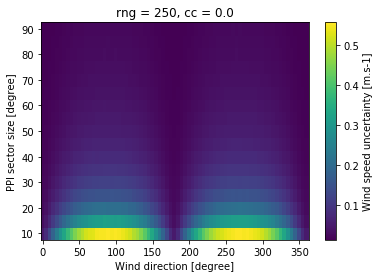

In [53]:
ds.u_ws.sel(rng=250, cc = 0).plot()

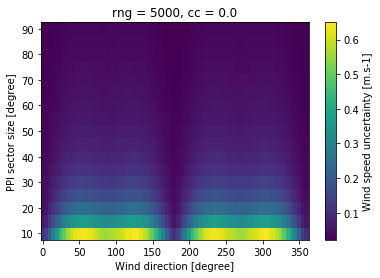

In [54]:
ds.u_ws.sel(rng=5000, cc = 0).plot()